In [1]:
import os, sys, random
from sys import platform
_base_path = '\\'.join(os.getcwd().split('\\')[:-1]) + '\\' if platform == 'win32' else '/'.join(os.getcwd().split('/')[:-1]) + '/'
sys.path.append(_base_path)
from monai.utils import set_determinism
from src.helpers.utils import make_dataset, get_device
import src.modules.plotting as plot
from src.modules.training import train_test_splitting, training_model, predict_model
from src.helpers.config import get_config
from src.modules.preprocessing import get_transformations
from src.models.segresnet import SegResNet
from src.models.unet import UNet
from src.models.swinunetr import SwinUNETR

In [2]:
_config = get_config()
saved_path = os.path.join(_base_path, _config.get('SAVED_FOLDER'))
reports_path = os.path.join(_base_path, _config.get('REPORT_FOLDER'))
preds_path = os.path.join(_base_path, _config.get('PRED_FOLDER'))
logs_path = os.path.join(_base_path, _config.get('LOG_FOLDER'))
if platform == 'win32':
	saved_path = saved_path.replace('/', '\\')
	reports_path = reports_path.replace('/', '\\')
	preds_path = preds_path.replace('/', '\\')
	logs_path = logs_path.replace('/', '\\')

In [3]:
set_determinism(seed=3)
random.seed(3)

In [4]:
data_path = make_dataset(dataset='glioma', verbose=False)
train_data, eval_data, test_data = train_test_splitting(data_path, reports_path=reports_path, load_from_file=True)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

                    TRAINING            EVALUATION          TESTING             

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

subjects            724 (64.0 %)        182 (16.0 %)        227 (20.0 %)        

sessions            800 (63.95 %)       202 (16.15 %)       249 (19.9 %)        



In [5]:
_models = {
	'SegResNet': SegResNet(
		init_filters=16,
		in_channels=4,
		out_channels=3,
		dropout_prob=0.2
	),
	'UNet': UNet(
        spatial_dims=3,
        in_channels=4,
        out_channels=3,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2)
    ),
	'SwinUNETR': SwinUNETR(
        img_size=(128, 128, 128),
        in_channels=4,
        out_channels=3,
        feature_size=48
    )
}
model = _models['SegResNet']

In [6]:
(
	train_transform,
	eval_transform,
	test_transform,
	post_test_transforms,
	post_trans
) = get_transformations(roi_size=(128, 128, 128) if model.name == 'SwinUNETR' else (240, 240, 160))

Input image shape: torch.Size([4, 240, 240, 155])
Input label shape: torch.Size([3, 240, 240, 155])


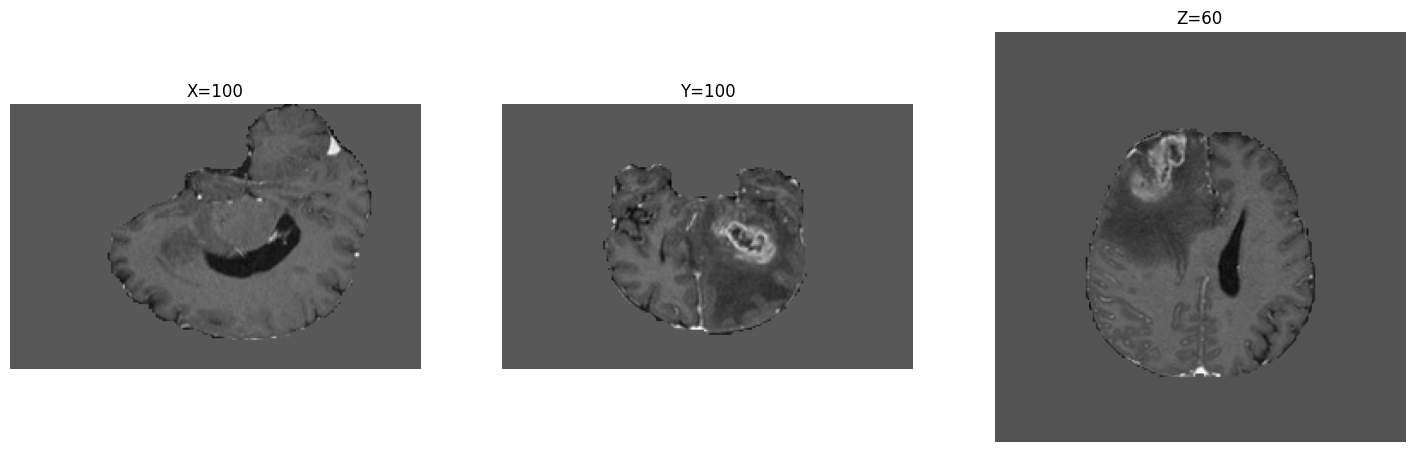

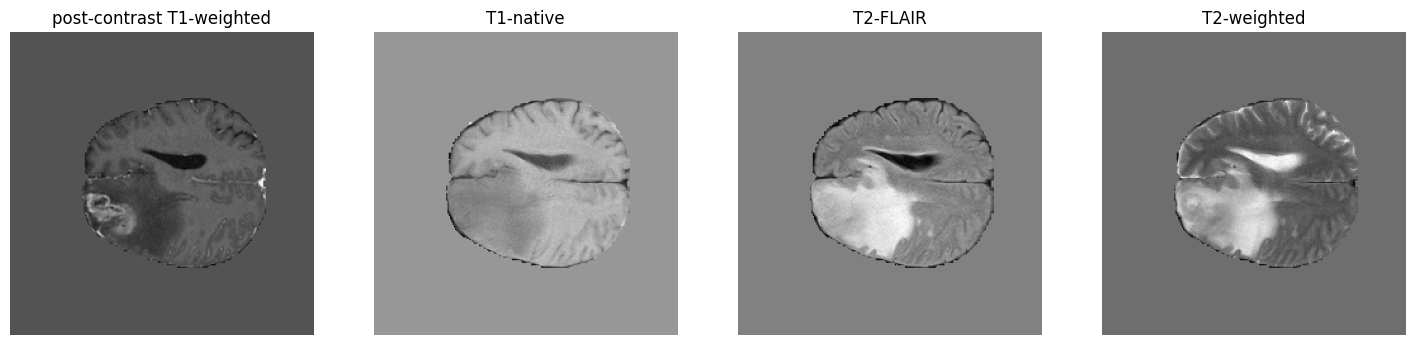

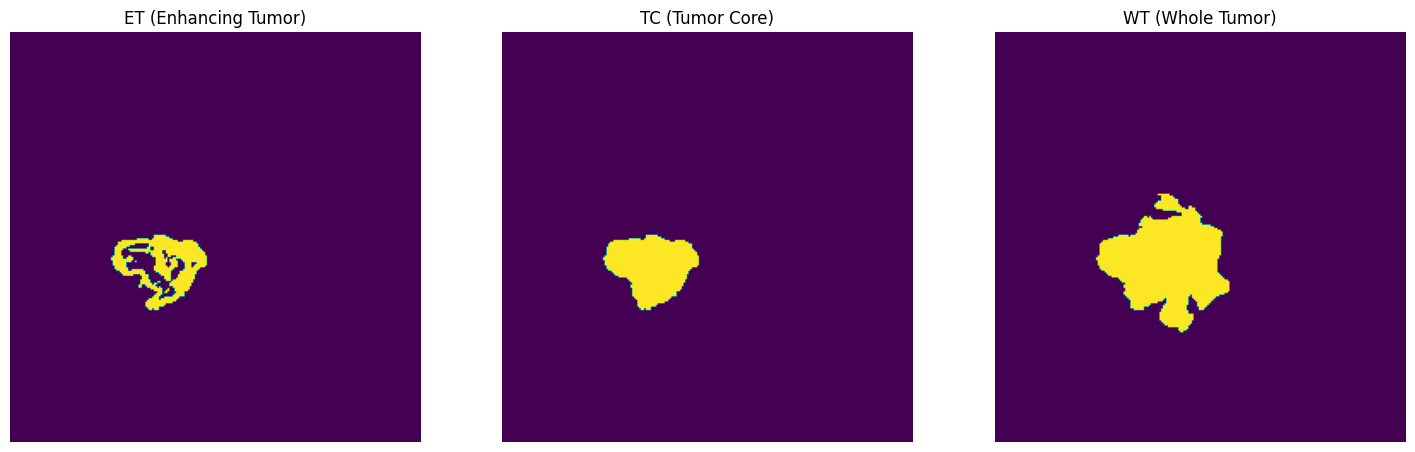

In [7]:
trans = train_transform(train_data[1])
print(f"Input image shape: {trans['image'].shape}")
print(f"Input label shape: {trans['label'].shape}")
plot.input_output(trans)

In [11]:
## NOTE: uncomment to execute the training phase.

# train_metrics = training_model(
# 	model = model,
# 	data = [train_data, eval_data],
# 	transforms = [train_transform, eval_transform, post_trans],
# 	epochs = 10,
# 	device = get_device(),
# 	paths = [saved_path, reports_path, logs_path],
#	verbose=True
# )

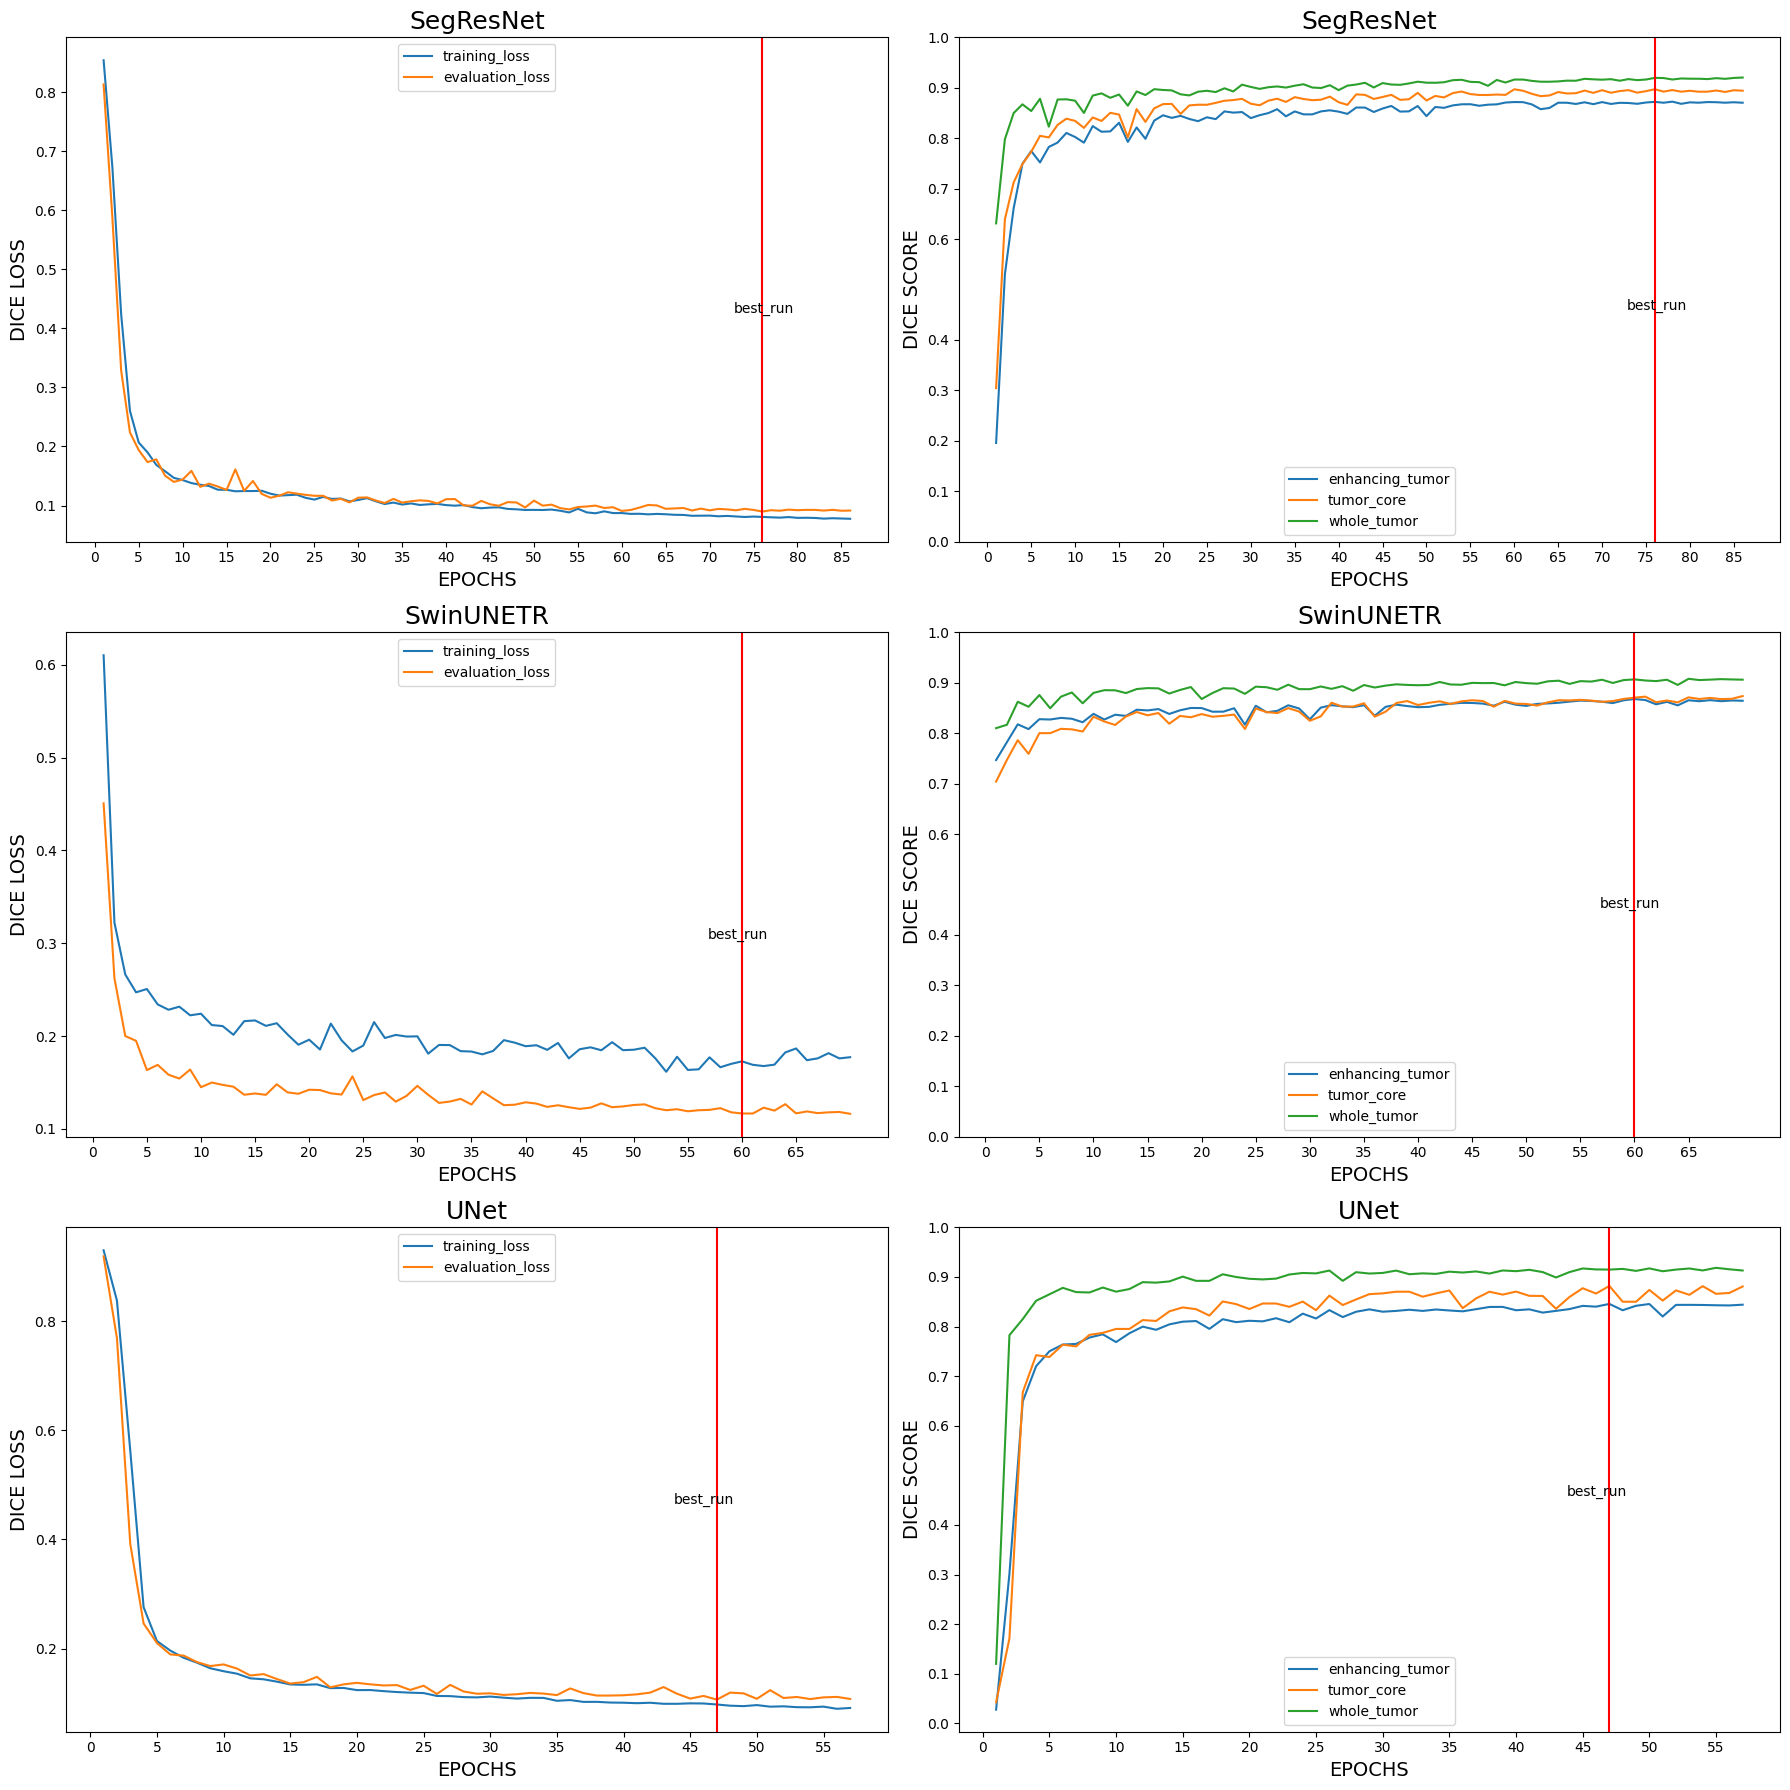

In [6]:
plot.training_values(reports_path)

In [13]:
## NOTE: uncomment to execute the prediction on the testing set.

# test_metrics = predict_model(
# 	model = model,
# 	data = test_data,
# 	transforms = [test_transform, post_test_transforms],
# 	device = get_device(),
# 	paths = [saved_path, reports_path, preds_path, logs_path],
#	verbose=True
# )

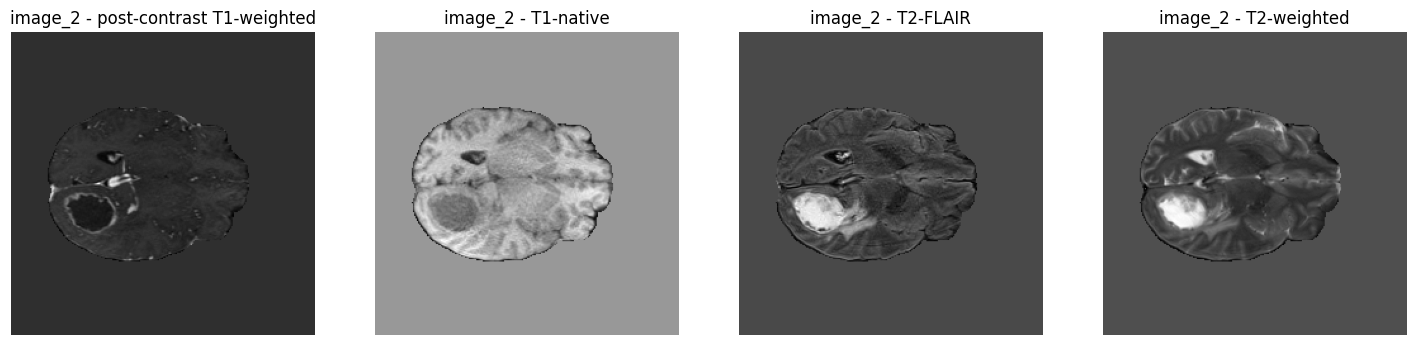

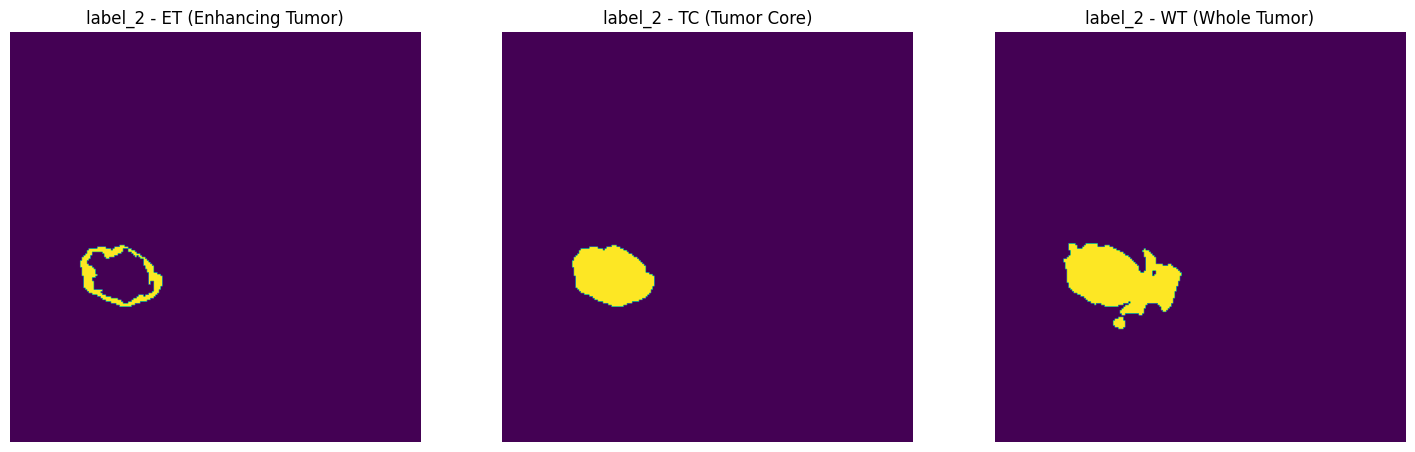

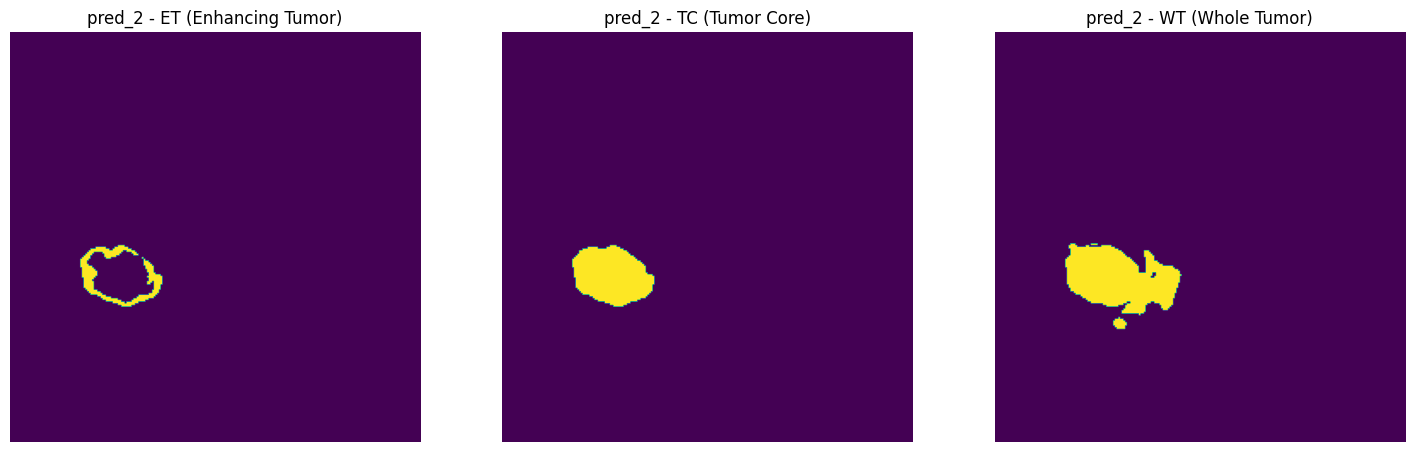

In [9]:
plot.prediction('SegResNet', preds_path)

In [7]:
plot.results(reports_path)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

                    DICE_ET        DICE_TC        DICE_WT        DICE_AVG       

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
SegResNet           0.8840         0.9112         0.9281         0.9078         
UNet                0.8483         0.8762         0.9134         0.8793         
SwinUNETR           0.8643         0.8917         0.9136         0.8899         
> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

                    HAUSDORFF_ET   HAUSDORFF_TC   HAUSDORFF_WT   HAUSDORFF_AVG  

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
SegResNet           3.6862         4.3484         4.9882         4.3410         
UNet                4.3396         5.7030         8.9595         6.3340         
SwinUNETR           5.2835         6.5476         8.5917         6.8076         
> > > > > > > > > > > > 